In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [3]:
del y_train
del y_test
del mndata
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).reshape(-1,28,28,1)

In [4]:
import sys
sys.path.append("../dnn_from_scratch")

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 287
Seed: 299


In [6]:
def generator():
    model=Sequential()
    model.add(dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((7,7,128)))
    model.add(upsampling())
    model.add(dropout(0.25))
    model.add(conv2d(128,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(upsampling())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.2))
    model.add(conv2d(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
2 reshape(reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 14, 14, 128)        echo             0
__________________________________________________________________________________________
4 dropout(dropout)        (None, 14, 14, 128)        echo             0
__________________________________________________________________________________________
5 conv2d(co

In [7]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(28,28,1)))
    model.add(max_pool())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(conv2d(128,kernel_size=3,activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 28, 28, 32)         leakyRelu        320
__________________________________________________________________________________________
2 max_pool(max_pool)      (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
3 dropout(dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 14, 14, 64)         leakyRelu        18496
__________________________________________________________________________________________
5 max_pool

In [10]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.001)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.001)

In [76]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_dis=np.zeros((2*batch_size,1),dtype=np.float32)
    y_dis[:batch_size]=1
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.normal(-1,1,(batch_size,100)).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
#         y_dis[:batch_size]=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
#         y_dis[batch_size:]=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_dis[:batch_size])
        dout2=d.train_on_batch(generated_images,y_dis[batch_size:])
        dloss=functions.cross_entropy(logits=dout2,labels=y_dis[batch_size:]).sum()
        # Treat noised input of generator as real data
        noise=np.random.normal(-1,1,(batch_size,100)).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        print("\rProgress: {:.2f} %     Dloss: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,time()-stt),end='')

In [ ]:
epochs=40
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    noise=np.random.normal(-1,1,(1,100)).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow(gen.reshape(28,28), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

EPOCH: 1 / 40
Progress: 3.75 %     Dloss: 0.0025819865986704826     Sample time: 1.644s    _

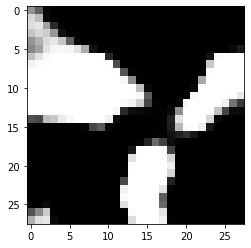

[[1.2958637e-09]]


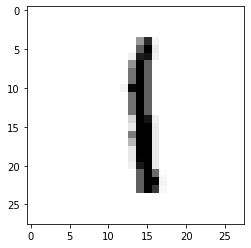

[[0.942999]]


In [75]:
noise=np.random.normal(-1,1,(1,100)).astype(np.float32)
gen=g.predict(noise)
plt.imshow(gen.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(gen))
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow(img.reshape(28,28), cmap='Greys')
plt.show()
print(d.predict(img))

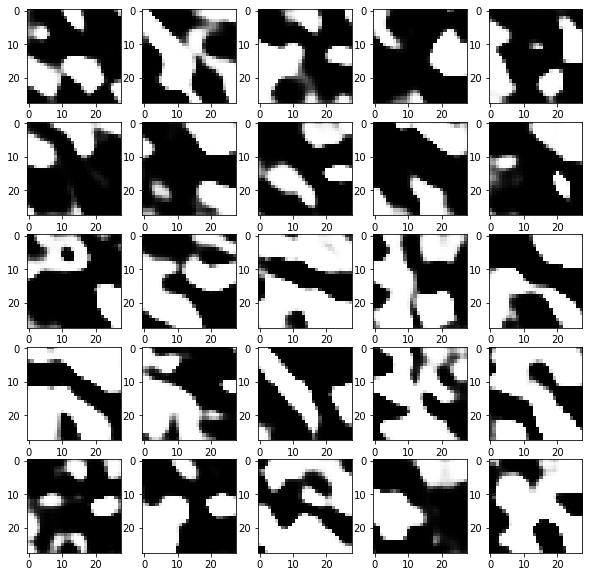

In [73]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.normal(-1,1,(25,100)).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow(gen[i].squeeze(), cmap='Greys')